In [1]:
#pip install rank_bm25

In [2]:
#pip install wordcloud

In [ ]:
#!python -m pip install -U spacy
#Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/
#!python -m pip install scispacy 
#!python -m pip install "https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_core_sci_sm-0.5.1.tar.gz"
#!python -m pip install "https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_ner_bionlp13cg_md-0.5.1.tar.gz"


In [38]:
#mandatory imports
import time
import re
from Bio import Entrez
import pandas as pd
import numpy as np
import spacy
import urllib.request, urllib.error, urllib.parse
import json
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from rank_bm25 import BM25Okapi
import scispacy 
import spacy 
#import en_core_sci_sm  #The model we are going to use from spacy import displacy from scispacy.abbreviation
import en_ner_bionlp13cg_md
from scispacy.abbreviation import AbbreviationDetector 
from scispacy.umls_linking import UmlsEntityLinker
print("Done.")

Done.


In [2]:
## Thesaurus declaration
thesaurus = {
    "Ivermectin" : ["IVM", "Ivermectin", "Avermectin", "avermectin", "ivermectin", "stromectol", "Stromectol", "Eqvalan", "Ivomec", "Mectizan", "Dihydroavermectin", "MK 933", "MK-933", "MK933","MK-0933", "L 640471", "L-640471", "C48H74O14", "IV", "IVM-654", "IVR-25", "IV-104", "IVE-11", "IVER-15"],
    "GABA" : ["GABA", "GABAergic", "gamma-aminobutyric acid"],
    "Zebrafish" : ["Zebrafish", "Danio rerio"],
    "COVID-19" : ["COVID-19", "COVID", "SARS-CoV-2"],
    "Glutamate" : ["Glutamate", "glutamate","Glu", "L-(+)-glutamate","L-Glu", "L-Glutamate", "L-glutamate", "L glutamate", "L glutamate"]
}
print("Done.")

Done.


In [3]:
def global_db_search(query_list, genes_list=[]):

    if len(genes_list) != 0:
        for i in query_list:
            for j in genes_list:
                query = i + j + "[tiab]"

                handle = Entrez.egquery(term=query)
                record = Entrez.read(handle)
                df = pd.DataFrame(record["eGQueryResult"]).head(2)
                df["Query"] = query
                append_data(df, 'global_query_res.csv', False)
                time.sleep(0.34)
    else:
        for i in query_list:
            handle = Entrez.egquery(term=i)
            record = Entrez.read(handle)
            df = pd.DataFrame(record["eGQueryResult"]).head(2)
            df["Query"] = i
            append_data(df, 'global_query_res.csv', False)
            time.sleep(0.34)
    return


## Function for reading in the df "summary" results
def read_in_results(file_name):

    # The converters are there so that each list is NOT inside a string
    res_df = pd.read_csv(file_name,  converters={"MainID_List": lambda x: x.strip("[]").replace("'", "").split(", "),
                                                    "P_Dates": lambda x: x.strip("[]").replace("'", "").split(", "),
                                                    "P_Years": lambda x: x.strip("[]").replace("'", "").split(", "),
                                                    "LinkedID_List": lambda x: x.strip("[]").replace("'", "").split(", "),
                                                    "Query_Count": int})
    return res_df


def esummary_info(in_webenv_key, in_query_key, db_name):

    # Obtaining DocSums for a set of IDs that are stored on the Entrez History server.
    handle = Entrez.esummary(db=db_name, webenv=in_webenv_key, query_key=in_query_key)
    record = Entrez.read(handle)

    publ_dates, publ_years = get_published_dates(record)

    if db_name == "pubmed":
        ids_list = get_pmcids(record)
    else:
        ids_list = get_pmids(record)

    return publ_dates, publ_years, ids_list


def get_published_dates(esummary_rec):

    retr_dates = []
    retr_years = []
    check = True
    i = 0
    for article in esummary_rec:
        # "PubDate" is often of the form: '2021 Nov 26'
        retr_dates.append(article["PubDate"])
        date = article["PubDate"].split()
        while(i < 2):
            if len(date[i]) == 4:
                p_year = int(date[i])
                i = 3
            else:
                i = i + 1
        #p_year = int(article["PubDate"].split()[0])
        #p_year = int(article["P_Years"].split()[0])
        #changed from PubDate to P_Years because of error when changing search term
        retr_years.append(p_year)

    return retr_dates, retr_years


def get_pmcids(esummary_rec):

    pmcids_list = []
    for i in esummary_rec:
        # If "pmc" is there, then this article also has a PMCID (i.e., it's also found in the PubMed Central db)
        if "pmc" in i["ArticleIds"]:
            pmcids_list.append(i["ArticleIds"]["pmc"])
        else:
            pmcids_list.append(np.NaN)

    return pmcids_list


def get_pmids(esummary_rec):

    pmids_list = []
    for i in esummary_rec:
        # '0' means that the article has no PMID (i.e., it's not found in the PubMed db)
        if i["ArticleIds"]["pmid"] == '0':
            pmids_list.append(np.NaN)
        else:
            pmids_list.append(i["ArticleIds"]["pmid"])

    return pmids_list


## Function that retrieves summary results from a given set of queries (which don't require a gene list)
def get_query_info_no_genes(query_in, db_name):

    # relevance: Records are sorted based on relevance to your search. (Relevance ranking)
    search_results = Entrez.read(
        Entrez.esearch(db=db_name, term=query_in, sort="relevance", retmax=5000, usehistory="y")
        )

    # NEED TO FIRST CHECK IF WE GOT ANY RESULTS FROM THAT QUERY
    if len(search_results["IdList"]) == 0:
        print("No Results.")
        return
    else:
        # With search_results, we will use its WebEnv value and QueryKey value
        p_dates, p_years, ids_list = esummary_info(search_results["WebEnv"], search_results["QueryKey"], db_name)

        time.sleep(0.34)

        return pd.DataFrame([[query_in, db_name, search_results['Count'], search_results['IdList'], p_dates, p_years, ids_list]],
                                columns=['Query', 'Db_Name', 'Query_Count', 'MainID_List', 'P_Dates', 'P_Years', 'LinkedID_List'])


## Function that retrieves summary results from a given set of queries (which requires a gene list)
def get_query_info(query_in, genes, db_name):

    gene_query = []
    query = ""

    for i in genes:
        # Example of db_name values in this use case: "pubmed" or "pmc"
        if db_name == "pubmed":
            # PubMed's Search field tag: Title/Abstract [tiab]
            query = query_in + i + "[tiab]"
        else:
            query = query_in + i

        # relevance: Records are sorted based on relevance to your search. (Relevance ranking)
        search_results = Entrez.read(
            Entrez.esearch(db=db_name, term=query, sort="relevance", retmax=5000, usehistory="y")
            )
     
        # NEED TO FIRST CHECK IF WE GOT ANY RESULTS FROM THAT QUERY
        if len(search_results["IdList"]) == 0:
            continue

        # With search_results, we will use its WebEnv value and QueryKey value
        p_dates, p_years, ids_list = esummary_info(search_results["WebEnv"], search_results["QueryKey"], db_name)
       
        gene_query.append([query, db_name, search_results['Count'], search_results['IdList'], p_dates, p_years, ids_list])
        time.sleep(0.34)
          
    return pd.DataFrame(gene_query, columns=['Query', 'Db_Name', 'Query_Count', 'MainID_List', 'P_Dates', 'P_Years', 'LinkedID_List'])


## Function for obtaining citation counts for the set of IDs found in the "summary" df
def cited_cnt_table(df_summary, db_name):

    elink_data = []
    link_name = ""

    if db_name == "pubmed":
        link_name = "pubmed_pubmed_citedin"
    else:
        link_name = "pmc_pmc_citedby"  # "pmc" is the other db_name in this use case

    for i in range(0, len(df_summary)):

        query_term = df_summary.iloc[i]["Query"]

        for id_num in df_summary.iloc[i]["MainID_List"]:

            record = Entrez.read(Entrez.elink(id=id_num, dbfrom=db_name, db=db_name, linkname=link_name))
         
            if len(record[0]["LinkSetDb"]) != 0:
                cited_counts = len(record[0]["LinkSetDb"][0]["Link"])
            else:
                # 'LinkSetDb' key contains empty list when an article has no citation counts
                cited_counts = 0
            elink_data.append([query_term, db_name, id_num, cited_counts])

            if (df_summary.iloc[i]["MainID_List"].index(id_num) + 1) % 3 == 0:
                time.sleep(0.34)

    return pd.DataFrame(elink_data, columns=["Query", "Db_Name", "Id_List", "Citation_Cnts"]) 


## Function that returns the Top-k results (pass in k as an argument to the function, input by the user)
def get_top_k(df, k_val):

    q_top_k = []

    for q in df["Query"].unique():
        matches_ids = []  # For each query version, these are the IDs meeting the criteria of having citation counts >= 25
        counts = []
        df_temp = df[df["Query"] == q]

        for i in range(0, len(df_temp)):
            if df_temp.iloc[i]["Citation_Cnts"] >= 25:
                matches_ids.append(int(df_temp.iloc[i]["Id_List"]))
                counts.append(df_temp.iloc[i]["Citation_Cnts"])
                if len(matches_ids) == k_val:
                    break
        if len(matches_ids) == 0:
            continue
        q_top_k.append([q, matches_ids, counts])

    top_k_df = pd.DataFrame(q_top_k, columns=["Query", "Top_"+str(k_val)+"_Ids", "Citation_Cnts"])

    return top_k_df


## Function that appends DataFrame rows to a CSV file
def append_data(df, file_name, is_new_file):

    if is_new_file:
        # if True, then
        df.to_csv(file_name, index=False)
    else:
        # False: This is an existing CSV file
        df.to_csv(file_name, mode='a', index=False, header=False)

    return

In [4]:
# Load in the model for English
nlp = spacy.load("en_core_web_sm")
# Can't retrieve XML if you don't have a query.
query = "GABA AND Glutamate"
Entrez.email = "n01365801@unf.edu.com"
df_q_pubmed = get_query_info_no_genes(query, "pubmed")
print("Done.")

C:\Users\danie\AppData\Roaming\Python\Python38\site-packages\spacy\util.py:877: UserWarning: [W095] Model 'en_core_web_sm' (3.3.0) was trained with spaCy v3.3 and may not be 100% compatible with the current version (3.4.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


Done.


In [5]:
"""
Documentation for fetch_pubmed()

This function's purpose is to use NCBI's E-Utils to get the body of articles, given an id.
The E-Util used in E-Fetch.
Future Work on this could be adjusting the argument, to allow for just a list of IDs, instead of a Pandas DataFrame slice.

Arguments:
    * ids: The IDs of articles from a Pandas DataFrame
Return Value: A list of the records.
"""
def fetch_pubmed(ids): 
    i = 0
    records_pubmed = []
    # Fetch all records pertaining to our queries.
    for row in ids:
        for uid in row:
            i = i + 1
            try:
                handle = Entrez.efetch(db="pubmed", id=uid, rettype='', retmode='xml')
            except:
                print("Fetch Failure at index" + str(i))
            try:
                record = Entrez.read(handle, validate=True, escape=True)
                records_pubmed.append(record)
            except:
                print("Read Failure at index" + str(i))
                

    # Be polite and flush/close the stream like a good programmer.
    handle.close()
    return records_pubmed
print("Done.")



Done.


In [6]:
df_q_pubmed.head()

,Query,Db_Name,Query_Count,MainID_List,P_Dates,P_Years,LinkedID_List
0,GABA AND Glutamate,pubmed,21997,"[33454439, 33438215, 35852458, 35840907, 32536...","[2022 Nov 2, 2022 Oct 31, 2022, 2022 Oct 26, 2...","[2022, 2022, 2022, 2022, 2022, 2022, 2022, 202...","[nan, nan, PMC9608171, nan, nan, nan, PMC96075..."


In [ ]:
records_pubmed = fetch_pubmed(df_q_pubmed['MainID_List'])


print(len(records_pubmed))
print("Done.")

In [9]:
"""
Documentation for invert_dict()

This function's sole purpose is to invert a dictionary, so that the values of the old are the keys of the new,
and the keys of the old are the values of the new, in list format.

Arguments:
    dictionary: The dictionary to be inverted.
Return Value: The inverted dictionary following the above design.
"""
def invert_dict(dictionary):
    dict_inverted = {} # output
    for (k, v) in dictionary.items():
        if v in dict_inverted.keys():
            dict_inverted[v].append(k)
        else:
            dict_inverted[v] = [k]
            
    return dict_inverted
print("Done.")

Done.


In [34]:
"""
Documentation for clean_text()

This function intakes a text string and removes punctuation that does not signal the end of a sentence.

Arguments:
    text: a string of text
Return Value: 
    clean_string: a string without punctuation
"""
def clean_text(text):
    try:
        #text_alphanumeric = re.sub(r'[^a-zA-Z0-9]', ' ', text)
        clean_string = re.sub(r'[^\w\s]', '', text)
        return clean_string
    except:
        print("error")
        return None
    
"""
Documentation for stopword_remove()

This function intakes a text string and removes english stopwords from nlp.Defaults.stop_words.

Arguments:
    text: a string of text
Return Value: 
    clean_string: a string without stopwords
"""

def stopword_remove(text):
    text_for_removal = text.split(" ")
    tokens_filtered= [word for word in text_for_removal if not word in nlp.Defaults.stop_words]
    return ' '.join(tokens_filtered)

"""
Documentation for stopword_remove()

This function is used as a preprocessing pipeline to call the clean_text() and stopword_remove() functions.

Arguments:
    text: a string of text
Return Value: 
   final_text: a string without english stopwords and non-stopping punctuation
"""

def preprocess(text):
    text_no_punct = clean_text(text)
    final_text = stopword_remove(text_no_punct)
    return final_text


In [11]:
"""
Documentation for bm_reranking()

This function will use find_comentions(), invert_dict(), and bm25 Okapi to create a ranking of the articles.
The articles will be identified by UID.

Future additions to this reranking function include using Ms. Victoria's get_top_k() and cited_cnt_table() functions to add in the
25 citation requirement for credibility. Other work includes breaking out some functionality into other functions in order to clean up the mess.

Arguments:
    * records: A list of XML Objects returned by E-Fetch.
    * query_terms: A list of query_terms. These then get selected out of the Thesaurus.
Return Value: 
    rankings: The rankings for the records. Type is a Pandas DataFrame.
    bmtop15: Top 15 ranked records.
    top_100: Top 100 of the rankings.
"""
def bm_reranking(records, query_terms):
    # snippet from https://stackoverflow.com/questions/29216889/slicing-a-dictionary
    # While in the answer, they add a check to make sure the key is in original dict
    # (the thesaurus in this case), it is safe to assume that the key is in the dict,
    # because the thesaurus should contain all possible terms.
    inner_thesaurus = {k:thesaurus[k] for k in query_terms}
    #print(inner_thesaurus)
    # DataFrame Data
    pmids = []
    titles = []
    abstracts = []
    token_abstracts = []
    relevancy_score = {}
    abstract_score = []
    comention_sentences = []
    tokenized_queries = []
    i = 0
    j = 0
    for record in records:
        # Some records do not have an Abstract (???) so we need to check for an abstract
        # TODO: Deal with the articles that don't have abstracts
        try:
            pmid = str(record['PubmedArticle'][0]['MedlineCitation']['PMID'])
            article_keys = record['PubmedArticle'][0]['MedlineCitation']['Article'].keys()
            if 'Abstract' in article_keys: # We have an Abstract
                # TODO: Stop rewriting this indexing mess every time.
                abstract_text = str(record['PubmedArticle'][0]['MedlineCitation']['Article']['Abstract']['AbstractText'])
                # Process the abstract
                
                #doc = nlp(abstract_text)
                
                #Preprocess abstracts with punct and stopword removal
                clean_abstract_text = preprocess(abstract_text)
                token_abstracts.append(clean_abstract_text.split(" "))
                #dataframe collection
                pmids.append(pmid)
                titles.append(str(record['PubmedArticle'][0]['MedlineCitation']['Article']['ArticleTitle']))
                abstract_text = "".join(str(i) for i in (record['PubmedArticle'][0]['MedlineCitation']['Article']['Abstract']['AbstractText']))
                abstracts.append(abstract_text)
        except:
            print("Record indexed at " + str(i) + " PMID not found.")
        i = i + 1
        j = j + 1
    
    bm25 = BM25Okapi(token_abstracts)
    
    for key in inner_thesaurus.keys():
        tokenized_queries = inner_thesaurus[key] + tokenized_queries
    
    doc_scores = bm25.get_scores(tokenized_queries)
   
    print(tokenized_queries)
    
    prerankings = pd.DataFrame(data=[pmids, titles, abstracts, doc_scores]).transpose()
    prerankings.columns = ["PMID", "Title", "Abstract", "BM25 Relevancy Score"]
    bmrankings= prerankings.sort_values(by=["BM25 Relevancy Score"], ascending=False).reset_index(drop=True)
    
    return bmrankings.iloc[:15], bmrankings

bmtop15,bmrankings = bm_reranking(records_pubmed, ["GABA","Glutamate"])

Record indexed at 4843 PMID not found.
['Glutamate', 'glutamate', 'Glu', 'L-(+)-glutamate', 'L-Glu', 'L-Glutamate', 'L-glutamate', 'L glutamate', 'L glutamate', 'GABA', 'GABAergic', 'gamma-aminobutyric acid']


In [12]:
print(bmtop15)
print(bmrankings[:100])
bmtop15.to_csv("Glutamate and GABA_BMstopwordtest.csv")
print("Done.")

        PMID                                              Title  \
0   34354048  Ventromedial prefrontal cortex/anterior cingul...   
1   15875487  Diffusional extrasynaptic neurotransmission vi...   
2   12708518  Extracellular glutamate increases in the later...   
3   24755074  Glutaminase catalyzes reaction of glutamate to...   
4   15149801  Relationships between glutamine, glutamate, an...   
5   11053233  Glutamate, GABA and precursor amino acids in a...   
6   21271723  Proteolysis and bioconversion of cereal protei...   
7   12657662  Neuronal glutamate uptake Contributes to GABA ...   
8   12467378             GABA and glutamate in the human brain.   
9   15712869  [Determination of gamma-aminobutyric acid and ...   
10  35260698  Lower glutamate and GABA levels in auditory co...   
11  29203179  Neurotransmitters in the mediation of cerebral...   
12  21971608  Effects of glutamate decarboxylase and gamma-a...   
13  11986998  Glutamate and GABA systems as targets for nove..

In [35]:
"""
Documentation for find_comentions()

Future Work for this function includes generalizing it to be able to handle both PubMed and PMC.
This will likely require some work on reranking() below, as it only handles PubMed formatted XML,
due to issues with PMC and Biopython present while writing this code.

Arguments:
    * thes: A dictionary containing the synonyms of query terms.
    * doc: A SpaCy Doc object that contains the text we are looking at.
Return Value: A tuple in the form of (sentences, proximity list)
"""
def find_comentions(thes, doc):
    sentences = []
    proximity_list = []
    #doc.tok = [tok.text for tok in doc if not tok.is_punct]
    #print(doc)
    #doc = abstract_text.split(" ")
    for sentence in doc.sents:
        #print(sentence)
        prev_term = ""
        term_seen = False
        first_i = 0
        for word in sentence:
            #print(word.text + str(word.i))
            for term in thes.keys():
                #print(term)
                if term_seen:
                    if (word.text in thes[term]) and (word.text not in thes[prev_term]):
                        #print(word.text + "Calculated!!")
                        #print(word.i)
                        proximity_list.append(int(word.i - first_i))
                        first_i = word.i
                        prev_term = term
                        sentences.append(str(sentence))
                        break
                elif (word.text in thes[term]):
                    #print(word.text)
                    #print(word.i)
                    term_seen = True
                    first_i = word.i
                    prev_term = term
                    break
    
    return (str(sentences), proximity_list)
print("Done.")

Done.


In [58]:
import scispacy 
import spacy 
#import en_core_sci_sm  #The model we are going to use from spacy import displacy from scispacy.abbreviation
import en_ner_bionlp13cg_md
from scispacy.abbreviation import AbbreviationDetector 
from scispacy.umls_linking import UmlsEntityLinker
#text = "Neurons are metabolically handicapped in the sense that they are not able to perform de novo synthesis of neurotransmitter glutamate and gamma-aminobutyric acid (GABA) from glucose!"
#text="To investigate the effect of propofol on the release of glutamate and gamma-aminobutyric acid (GABA) from rat hippocampal synatosomes, synaptosomes was made from hippocampus and incubated with artificial cerebrospinal fluid (aCSF). With the experiment of Ca(2+)-dependent release of glutamate and GABA, dihydrokainic acid (DHK) and nipectic acid were added into aCSF. For the observation of Ca(2+)-independent release of glutamate and GABA, no DHK, nipectic acid and Ca2+ were added from aCSF. The release of glutamate and GABA were evoked by 20 micromol/L veratridine or 30 mmol/L KCI. The concentration of glutamate and GABA in aCSF was measured by using high-performance liquid chromatography (HPLC). 30, 100 and 300 micromol/L propofol significantly inhibited veratridine-evoked Ca(2+)-dependent release of glutamate and GABA (P < 0.01 or P < 0. 05). However, propofol showed no effect on elevated KCl-evoked Ca(2+)-dependent release of glutamate and GABA (P > 0.05). Veratridine or elevated KCI evoked Ca(2+)-independent release of glutamate and GABA was not affected significantly by propofol (P > 0.05). Propofol could inhibit Ca(2+)-dependent release of glutamate and GABA. However, it has no effect on the Ca(2+)-independent release of glutamate and GABA."                   
text = "Dramatic structural and functional remodeling occurs in the postpartum brain for the establishment of maternal care, which is essential for the growth and development of young offspring. Glutamate and GABA signaling are critically important in modulating multiple behavioral performances. Large scale signaling changes occur in the postpartum brain, but it is still not clear to what extent the neurotransmitters glutamate and GABA change and whether the ratio of glutamate/GABA remains balanced."
print(text)
text= re.sub(r'/', ' ', text)
doc = nlp(text)
text_no_punct = [token for token in doc if not (token.is_punct or token.is_left_punct or token.is_right_punct) or (token.text ==  ("." or "!" or "?"))]

text_no_punct= ' '.join(token.text for token in text_no_punct)
#print("Text_No_Punct: " + text_no_punct)
tokens_filtered = nlp(text_no_punct)
#print(tokens_filtered)

#nlp1 = spacy.load("en_core_sci_sm")
nlp1 = spacy.load("en_ner_bionlp13cg_md")
doc1 = nlp1(text)  
print("Scispacy tokens:\n")
for token in doc1:
    print(token)
#print(list(doc1.sents))

text_no_punct1 = [token for token in doc1 if not (token.is_punct or token.is_left_punct or token.is_right_punct) or (token.text ==  ("." or "!" or "?"))]
text_no_punct1= ' '.join(token.text for token in text_no_punct1)
print("Text_no_punct SciSPacy: " + text_no_punct1)
doc_no_punct= nlp1(text_no_punct1)

print("Scispacy tokens:\n")
for token in doc_no_punct:
    print(token)
    
#text_final = [token for token in doc_no_punct if (token.is_entity() and ]
#print(doc)
#text_for_removal = text_no_punct.split(" ")
#tokens_filtered= [word for word in text_for_removal if not word in nlp.Defaults.stop_words]
query_terms= ["GABA","Glutamate"]
inner_thesaurus = {k:thesaurus[k] for k in query_terms}
(comention_sents, proximity_count) = find_comentions(doc=doc_no_punct, thes=inner_thesaurus)
print(proximity_count)
if (len(proximity_count) != 0):
    relevancy_score = sum([1/count for count in proximity_count])
else:
    relevancy_score = 0
print(relevancy_score)
print(comention_sents)

Dramatic structural and functional remodeling occurs in the postpartum brain for the establishment of maternal care, which is essential for the growth and development of young offspring. Glutamate and GABA signaling are critically important in modulating multiple behavioral performances. Large scale signaling changes occur in the postpartum brain, but it is still not clear to what extent the neurotransmitters glutamate and GABA change and whether the ratio of glutamate/GABA remains balanced.
Scispacy tokens:

Dramatic
structural
and
functional
remodeling
occurs
in
the
postpartum
brain
for
the
establishment
of
maternal
care
,
which
is
essential
for
the
growth
and
development
of
young
offspring
.
Glutamate
and
GABA
signaling
are
critically
important
in
modulating
multiple
behavioral
performances
.
Large
scale
signaling
changes
occur
in
the
postpartum
brain
,
but
it
is
still
not
clear
to
what
extent
the
neurotransmitters
glutamate
and
GABA
change
and
whether
the
ratio
of
glutamate
GABA
re

In [52]:
"""
Documentation for reranking()

This function will use find_comentions(), invert_dict(), and word_proximity() to create a general ranking of the articles.
The articles will be identified by UID.

Future additions to this reranking function include using Ms. Victoria's get_top_k() and cited_cnt_table() functions to add in the
25 citation requirement for credibility. Other work includes breaking out some functionality into other functions in order to clean up the mess.

Arguments:
    * records: A list of XML Objects returned by E-Fetch.
    * query_terms: A list of query_terms. These then get selected out of the Thesaurus.
Return Value: 
    rankings: The top 15 rankings for the records. Type is a Pandas DataFrame.
    prerankings: Unsorted scored dataframe of records. Used for comparison to bm25 rankings.
    top_100
    
"""
### TODO: Break apart this function into smaller functions
    # Namely, creation of combined_criteria, creation of top_15, and creation of DataFrame
def reranking(records, query_terms):
    # snippet from https://stackoverflow.com/questions/29216889/slicing-a-dictionary
    # While in the answer, they add a check to make sure the key is in original dict
    # (the thesaurus in this case), it is safe to assume that the key is in the dict,
    # because the thesaurus should contain all possible terms.
    inner_thesaurus = {k:thesaurus[k] for k in query_terms}

    # DataFrame Data
    pmids = []
    titles = []
    abstracts = []
    relevancy_score = {}
    comention_sentences = []
    i = 0
    j = 0
    for record in records:
        # Some records do not have an Abstract (???) so we need to check for an abstract
        # TODO: Deal with the articles that don't have abstracts
        try:
            pmid = str(record['PubmedArticle'][0]['MedlineCitation']['PMID'])
            article_keys = record['PubmedArticle'][0]['MedlineCitation']['Article'].keys()
            if 'Abstract' in article_keys: # We have an Abstract
                # TODO: Stop rewriting this indexing mess every time.
                abstract_text = str(record['PubmedArticle'][0]['MedlineCitation']['Article']['Abstract']['AbstractText'])
                # Process the abstract
                #CHANGE using raw string for comention
                
                #doc = nlp(abstract_text)
                #removes punctuation that does not indicate the end of a sentence
                #text_no_punct = [token for token in doc if not (token.is_punct or token.is_left_punct or token.is_right_punct) or (token.text ==  ("." or "!" or "?"))]
                #text_no_punct= ' '.join(token.text for token in text_no_punct)
                #doc = nlp(text_no_punct)
                
                abstract_text = re.sub(r'/', ' ', abstract_text) #removes / characters because of unique case involving scispacy NER, combines query1/query2 into an unrecognizable token
                doc = nlp1(abstract_text) 
                #removes punctuation that does not indicate the end of a sentence
                text_no_punct = [token for token in doc if not (token.is_punct or token.is_left_punct or token.is_right_punct) or (token.text ==  ("." or "!" or "?"))]
                text_no_punct= ' '.join(token.text for token in text_no_punct)
                
                doc_no_punct= nlp1(text_no_punct)
                (comention_sents, proximity_count) = find_comentions(doc=doc_no_punct, thes=inner_thesaurus)
                #(comention_sents, proximity_count) = find_comentions(doc=abstract_text, thes=inner_thesaurus)
                # DataFrame data collection
                pmids.append(pmid)
                if (len(proximity_count) != 0):
                    relevancy_score[pmid] = sum([1/count for count in proximity_count])
                else:
                    relevancy_score[pmid] = 0
                titles.append(str(record['PubmedArticle'][0]['MedlineCitation']['Article']['ArticleTitle']))
                try:
                    
                    #FIXME: have to repeat these commands in order to have proper formatting also may not be appending al lcomention sentences due to tokenization changes
                    abstract_text = "".join(str(i) for i in (record['PubmedArticle'][0]['MedlineCitation']['Article']['Abstract']['AbstractText']))
                    abstracts.append(abstract_text)
                    doc = nlp(abstract_text)
                    (comention_sents, proximity_count) = find_comentions(doc=doc, thes=inner_thesaurus)
                    comention_sentences.append(comention_sents)
                except:
                    print("Reformatting error at " + str(i) + ".")
                
        except:
            print("Record indexed at " + str(i) + " PMID not found.")
        i = i + 1
        j = j + 1
    print("Num records proccessed: " + str(j))
    
    # Relevancy score will be used to calculate the index.
    prerankings = pd.DataFrame(data=[pmids, titles, abstracts, relevancy_score.values(), comention_sentences]).transpose()
    prerankings.columns = ["PMID", "Title", "Abstract", "Relevancy Score", "Comention Sentences"]
    #FIXME: remove plotting
    
    
    
    #formatting for output
    
    relevancy_score_inverted = invert_dict(relevancy_score)
    # Gathering the top 15 abstracts based on the relevancy score.
    # We conglomerate all of the scores into a single list, flatten it, and then simply slice out the first 15 elements.
    top_15 = []
    for i in sorted(relevancy_score_inverted.keys(), reverse=True):
        top_15.append(relevancy_score_inverted[i])
    # This list comprehension is flattening the list of lists produced by combined_criteria filtering.
    top_15 = [x for xs in top_15 for x in xs]
    top_15 = top_15[:15]
    prerankings.astype({'Comention Sentences': 'string'}).dtypes
    prerankings["Comention Sentences"] = prerankings["Comention Sentences"].apply(lambda x: str(x).strip("[]"))
    
    #getting top 100 for word clouds
    top_100 = []
    for i in sorted(relevancy_score_inverted.keys(), reverse=True):
        top_100.append(relevancy_score_inverted[i])
    # This list comprehension is flattening the list of lists produced by combined_criteria filtering.
    top_100 = [x for xs in top_100 for x in xs]
    top_100 = top_100[:100]
    
    # Now that we have the UIDs of our top 15, we can grab them
    #FIXME: need to redo top 15 selections with iloc like function for BMRANKINGS
    prerankings = prerankings.sort_values(by="Relevancy Score", ascending=False).reset_index(drop=True)
    rankings = prerankings[prerankings["PMID"].isin(top_15)].sort_values(by="Relevancy Score", ascending=False).reset_index(drop=True)
    top_100ranked = prerankings[prerankings["PMID"].isin(top_100)].sort_values(by="Relevancy Score", ascending=False).reset_index(drop=True)
    return rankings, top_100ranked, prerankings

# FIXME: Do NOT hardcode the query_terms, pull them in from the query.
rankings, top_100, prerankings = reranking(records_pubmed, ["GABA","Glutamate"])


Record indexed at 4843 PMID not found.
Num records proccessed: 4969


Text(0, 0.5, 'Log Frequency')

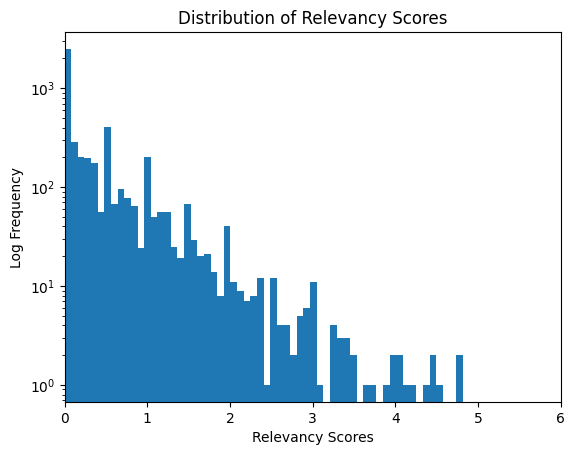

In [47]:
ax = prerankings["Relevancy Score"].plot(kind = 'hist', logy = True, bins = 60, title = "Distribution of Relevancy Scores",
                                    xlim = (0,6))
ax.set_xlabel("Relevancy Scores")
ax.set_ylabel("Log Frequency")


In [17]:
#needed for merge
prerankings[prerankings.index.name] = prerankings.index
prerankings["Comention Score Rank"]= prerankings[prerankings.index.name]
print("Done.")

Done.


In [18]:
prerankings.head()

,PMID,Title,Abstract,Relevancy Score,Comention Sentences,None,Comention Score Rank
0,25451092,"Glutamate, GABA, and glutamine are synchronous...",Dramatic structural and functional remodeling ...,4.816667,'Glutamate and GABA signaling are critically i...,0,0
1,16696330,Effect of propofol on glutamate and gamma-amin...,To investigate the effect of propofol on the r...,4.75,'To investigate the effect of propofol on the ...,1,1
2,25074444,Neurochemistry of major depression: a study us...,Magnetic resonance spectroscopy (MRS) is an ac...,4.5,'Previous studies in depressed patients have f...,2,2
3,17177337,[Effect of dialysis time in vivo on recovery o...,To investigate the variety of vitro recovery o...,4.494048,'Probes were dialyzed in the amino acids stand...,3,3
4,15009139,"Depolarization, exocytosis and amino acid rele...",External osmolarity reduction (20%) led to lab...,4.416667,'External osmolarity reduction (20%) led to la...,4,4


In [19]:
bmrankings_merged = pd.merge(left = bmrankings, right = prerankings, left_on = "PMID", right_on ="PMID")
bmrankings_mergedtop15 = bmrankings_merged.iloc[:15]

In [20]:
bmrankings_mergedtop15.head()

,PMID,Title_x,Abstract_x,BM25 Relevancy Score,Title_y,Abstract_y,Relevancy Score,Comention Sentences,None,Comention Score Rank
0,34354048,Ventromedial prefrontal cortex/anterior cingul...,Glutamate (Glu) and gamma-aminobutyric acid (G...,15.288197,Ventromedial prefrontal cortex/anterior cingul...,Glutamate (Glu) and gamma-aminobutyric acid (G...,0.38511,'Glutamate (Glu) and gamma-aminobutyric acid (...,1530,1530
1,15875487,Diffusional extrasynaptic neurotransmission vi...,Glutamate and GABA are the main synaptic neuro...,12.661762,Diffusional extrasynaptic neurotransmission vi...,Glutamate and GABA are the main synaptic neuro...,2.0,'Glutamate and GABA are the main synaptic neur...,137,137
2,12708518,Extracellular glutamate increases in the later...,Glutamate injected into the lateral hypothalam...,12.536488,Extracellular glutamate increases in the later...,Glutamate injected into the lateral hypothalam...,0.785354,'Glutamate injected into the lateral hypothala...,827,827
3,24755074,Glutaminase catalyzes reaction of glutamate to...,"Here, for the first time, we report an NMR spe...",12.508361,Glutaminase catalyzes reaction of glutamate to...,"Here, for the first time, we report an NMR spe...",0.435833,"'In the first step, Glnase rapidly hydrolyzes ...",1490,1490
4,15149801,"Relationships between glutamine, glutamate, an...","Glutamine (Gln), glutamate (Glu) and gamma-ami...",12.431912,"Relationships between glutamine, glutamate, an...","Glutamine (Gln), glutamate (Glu) and gamma-ami...",1.727778,"'Glutamine (Gln), glutamate (Glu) and gamma-am...",193,193


In [21]:
bmcomparison =  bmrankings_mergedtop15.filter(['PMID','Title_x','Abstract_x', 'BM25 Relevancy Score','Relevancy Score', 'Comention Score Rank'], axis=1)
bmcomparison.head()

,PMID,Title_x,Abstract_x,BM25 Relevancy Score,Relevancy Score,Comention Score Rank
0,34354048,Ventromedial prefrontal cortex/anterior cingul...,Glutamate (Glu) and gamma-aminobutyric acid (G...,15.288197,0.38511,1530
1,15875487,Diffusional extrasynaptic neurotransmission vi...,Glutamate and GABA are the main synaptic neuro...,12.661762,2.0,137
2,12708518,Extracellular glutamate increases in the later...,Glutamate injected into the lateral hypothalam...,12.536488,0.785354,827
3,24755074,Glutaminase catalyzes reaction of glutamate to...,"Here, for the first time, we report an NMR spe...",12.508361,0.435833,1490
4,15149801,"Relationships between glutamine, glutamate, an...","Glutamine (Gln), glutamate (Glu) and gamma-ami...",12.431912,1.727778,193


In [22]:
bmcomparison.rename(columns={"Title_x": "Title", "Abstract_x": "Abstract","Relevancy Score":"Comention Relevancy Score"}, inplace = True)
bmcomparison.head()

,PMID,Title,Abstract,BM25 Relevancy Score,Comention Relevancy Score,Comention Score Rank
0,34354048,Ventromedial prefrontal cortex/anterior cingul...,Glutamate (Glu) and gamma-aminobutyric acid (G...,15.288197,0.38511,1530
1,15875487,Diffusional extrasynaptic neurotransmission vi...,Glutamate and GABA are the main synaptic neuro...,12.661762,2.0,137
2,12708518,Extracellular glutamate increases in the later...,Glutamate injected into the lateral hypothalam...,12.536488,0.785354,827
3,24755074,Glutaminase catalyzes reaction of glutamate to...,"Here, for the first time, we report an NMR spe...",12.508361,0.435833,1490
4,15149801,"Relationships between glutamine, glutamate, an...","Glutamine (Gln), glutamate (Glu) and gamma-ami...",12.431912,1.727778,193


In [23]:
bmcomparison.to_csv("GABA_AND_GlutamateBM25vsComentionRanks01.csv")

In [53]:
REST_URL = "http://data.bioontology.org"
"""
Use of this requires a valid API Key.
This simply requires setting up an account at bioportal.bioonotology.org,
but do note that API Keys are meant to be secret, and probably more permanent than
what amounts to basically an intern's key.
"""
API_KEY = "0de90ddd-0da2-42ee-b0a0-2eb3b90dface"
ont = "HP,MDM"
def get_json(url):
    opener = urllib.request.build_opener()
    opener.addheaders = [('Authorization', 'apikey token=' + API_KEY)]
    return json.loads(opener.open(url).read())

abstract = "Ivermectin (IVM) is an antiparasitic drug that is widely used in domestic animals. In mammals, IVM acts as a γ-aminobutyric acid (GABA) receptor agonist. This neurotransmitter plays an important role in the regulation of female sexual behavior. The present study investigated the effects of therapeutic (0.2 mg/kg) and high (1.0 mg/kg) IVM doses on female sexual behavior in physiological and pharmacological conditions. Female rats in estrus or treated with estradiol valerate to induce sexual behavior 24 h before the experiments were used. Ivermectin was administered 15 min before the sexual observations. The number of lordosis events in 10 mounts was recorded to calculate the lordosis quotient. The intensity of lordosis (0 [no lordosis], 1 [low lordosis], 2 [normal lordosis] and 3 [exaggerated lordosis]) was scored. In estrus and hormonal treated female rats, both IVM doses decreased the intensity of the lordosis reflex and the percentage of females that presented high levels of lordosis (exaggerated lordosis). However, the number of females that presented lordosis was unaltered. We conclude that in both hormonal conditions, 0.2mg/kg IVM treatment reduced female sexual behavior and the execution of the lordosis reflex. The present results may be useful for avoiding the side effects of this drug in veterinary practice."
annotations = get_json(REST_URL + "/annotator?text=" + urllib.parse.quote(abstract) + "&ontologies=" + ont)

In [54]:
"""
Documentation for ann_extraction()

This function's purpose is to feed the queried abstracts into different bioontology databases for annotation and extract the terms found within.
Calls getAnnotations() for parsing o results and formatting.

Arguments:
    * ont: List of codes determining which ontologies to annotate from.
    * table: Pandas dataframe of records pulled from query.
Return Value: rankedAnnotations, a list of dictionaries with annotated terms separated by source ontology that can be set added as columns to the dataframe of choice.
"""
def ann_extraction(ont, table):
    #i = 0
    rankedAnnotations = []
    ranking = table
    for abstract in ranking["Abstract"]:
        #i = i +1
        #print("ABSTRACT " + str(i))
        annotations = (get_json(REST_URL + "/annotator?text=" + urllib.parse.quote(abstract) + "&ontologies=" 
                                + ont + "&roots_only=true&require_exact_match=true&exclude_synonyms=true"))
        rankedAnnotations.append(getAnnotations(annotations, ont))
         
    return rankedAnnotations
    
    
"""
Documentation for getAnnotations()

This function takes the returned JSON annotation objects from ann_extraction(), seperates the annotations by source ontology, and formats them for clean output.

Arguments:
    * ont: List of codes determining which ontologies to annotate from.
    * annotations: JSON formatted collection of annotation objects to be parsed for output.
Return Value: ontDict, a dictionary with the ontology codes as keys and a list of annotated terms from the source ontology as values.
"""
def getAnnotations(annotations, ont):
    ontCat = ont.split(",")
    ontDict={}
    for ont in ontCat:
        ontDict[ont] = []

    for result in annotations:
        class_details = result["annotatedClass"]
        try:
            class_details = get_json(result["annotatedClass"]["links"]["self"])
        except urllib.error.HTTPError:
            print(f"Error retrieving {result['annotatedClass']['@id']}")
            continue
        ontDict[str(class_details["links"]["ontology"].split("/")[-1])] += [class_details["prefLabel"]]
        

    return ontDict

columns = ann_extraction(ont, rankings)
top100_columns = ann_extraction(ont, top_100)


In [55]:
"""
Documentation for attachAnnotations()

This function takes the list of separated annotation dictionaries per abstract, checks for duplicates within each abstract, and formats them or attachment to the CSV.

Arguments:
    * ont: List of codes determining which ontologies to annotate from.
    * columns: List of dictionaries with separated annotations by ontology.
    * rankings: Dataframe of records from query.
Return Value: None
"""
#adds anotatons to rankings table
def attachAnnotations(ont, columns, rankings):

    sources = ont.split(",")
    for source in sources:
        cols = []
        for ele in columns:
            items = []
            temp = ele[source]
            for i in temp:
                if i not in items:
                    items.append(i)
            items = str(items)
            cols.append(items.strip("[]"))
        rankings[source] = cols
        
attachAnnotations(ont, columns, rankings)
attachAnnotations(ont, top100_columns, top_100)

#print(rankings)

In [27]:
#bm_annotation_cols = ann_extraction(ont, bmcomparison)
#attachAnnotations(ont, bm_annotation_cols, bmcomparison)

In [28]:
#bmranking_scored = pd.merge(left = bmrankings, right = prerankings, left_on = "PMID", right_on ="PMID")
#could use annotations doing rankings and prerankings
bmrankings_mergedtop15.to_csv("Glutamate and GABA_BM7.csv")

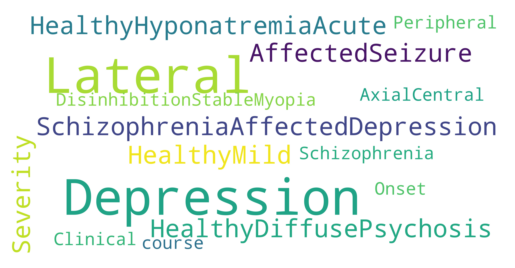

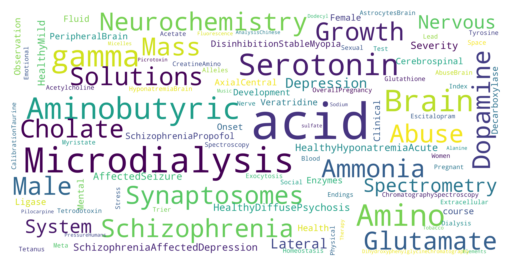

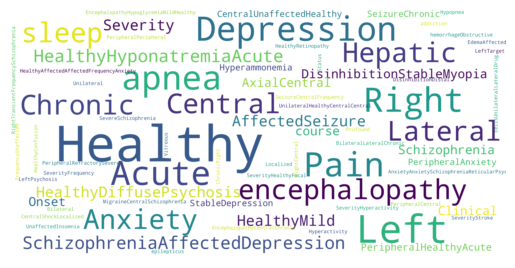

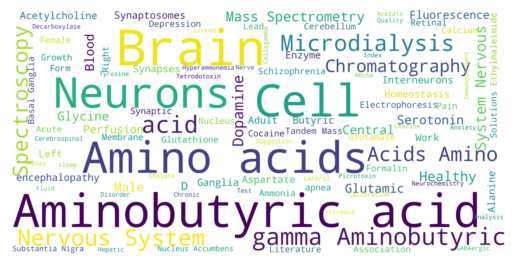

In [29]:
"""
Documentation generate_wordclouds()

Uses Wordcloud() to generate wordclouds for the annotated records.

Arguments:
    * ont: List of ontology codes.
    * rankings: Pandas dataframe of ranked items

"""
def generate_wordclouds(ont, rankings):
    sources = ont.split(",")
    text = ""
    
    for source in sources:
        temp = rankings[source]
        for items in temp:
            for element in items:
                text += element.strip("''")
       
        wordcloud = WordCloud(max_font_size=40, max_words=100, background_color="white", normalize_plurals = True, scale = 15 ).generate(text)
        plt.figure()
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.show()
        wordcloud = WordCloud().generate(text)
        
    # Create and generate a word cloud image:
        
generate_wordclouds(ont, rankings)
generate_wordclouds(ont, top_100)

In [57]:
# CSV output
rankings.to_csv("Glutamate and GABA15scispacy.csv")
print("Done.")

Done.
